In [1]:
import os
from io import StringIO 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from scipy import signal
from scipy.optimize import curve_fit

In [2]:
dir = 'C:\\Users\\wj2002\Dropbox (Heriot-Watt University Team)\\2021_HWU\Exp data-2021'
folder = '20221123_0_1%_PrYVO4_absorption_whitelight'
sub_folders = ['2.7K','90K','120K','150K','210K','248K']
file_name=['OD_013.csv','OD_013.csv','OD_013.csv','OD_013.csv','OD_022.csv','OD_022.csv']

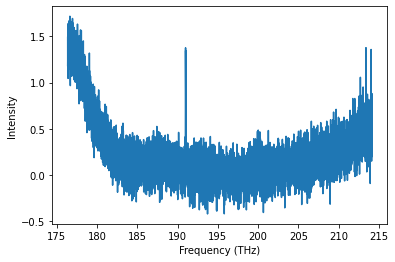

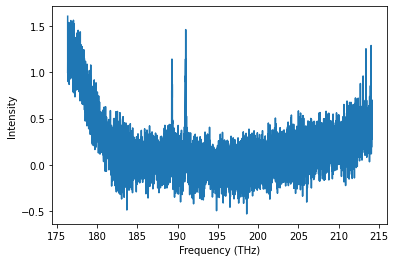

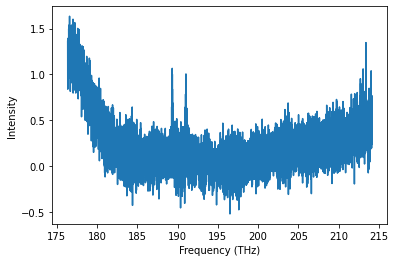

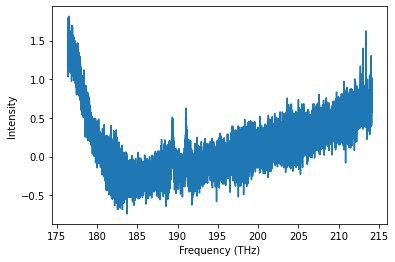

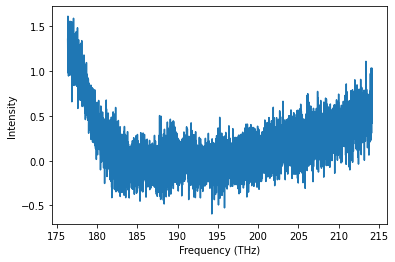

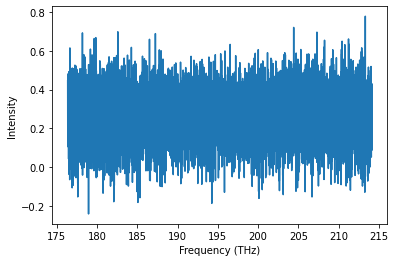

In [42]:
data=[]
data=pd.DataFrame(data)
for index,file in enumerate(file_name):
    path=dir + '\\' + folder + '\\' + sub_folders[index] + '\\'+file

    file_data = open(path, 'r')
    content = file_data.read()
    # change new line character from '\r\n' to '\n'
    lines = content.replace('\r', '').split('\n')
    # Remove the first and last 2 lines of the file
    # StringIO can be considered as a file stored in memory
    read_data=pd.read_csv(StringIO("\n".join(lines[99:-3])), header=None)
    #read_data=read_data.to_numpy() # Read the raw data when the laser is focused into the sample

    data[index*2]=read_data[0]
    data[index*2+1]=read_data[1]

    fig,ax=plt.subplots()
    ax.plot(read_data[0],read_data[1])
    ax.set_xlabel('Frequency (THz)')
    ax.set_ylabel('Intensity')

1
190.9904379418004
2
189.30919016511444
191.00637781756816
2
189.34879261606605
191.03603769313858
2
189.38396985433033
191.05236118488241
2
189.4820305118911
191.10755962830646


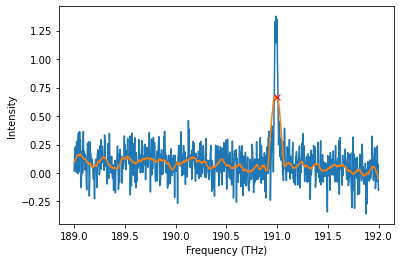

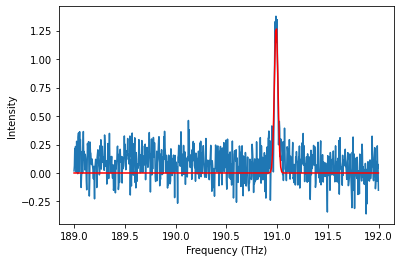

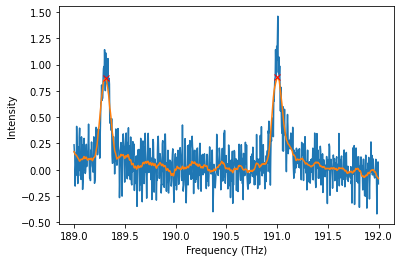

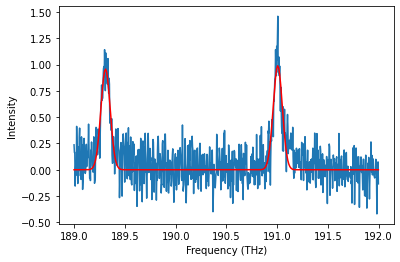

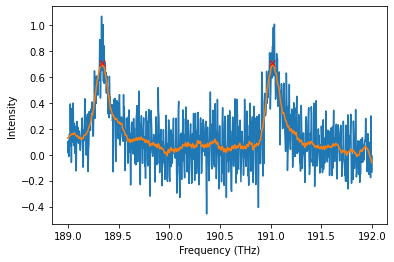

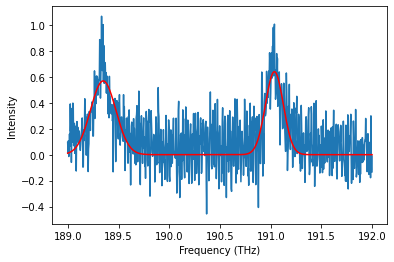

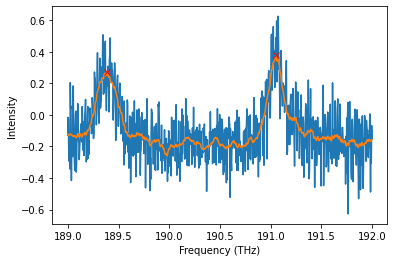

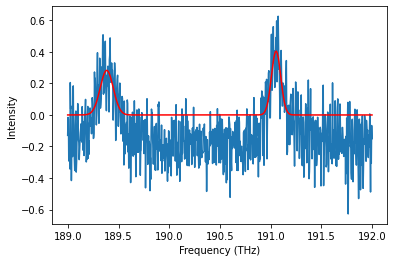

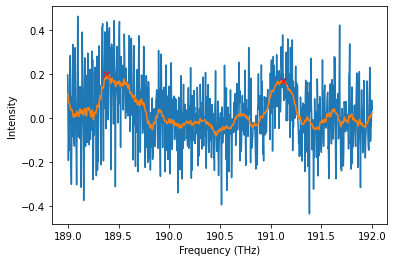

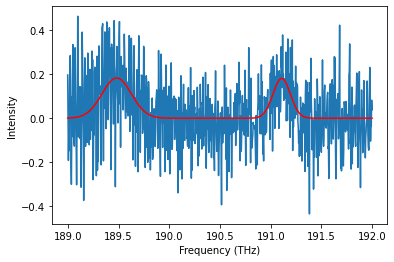

In [53]:
prominence_value=[0.5,0.5,0.4,0.1,0.1]
fitted_data=[]
fitted_data=pd.DataFrame(fitted_data)
fitted_data_normalised=[]
fitted_data_normalised=pd.DataFrame(fitted_data_normalised)

FWHM_0=np.zeros(len(file_name)-1)
f0_0=np.zeros(len(file_name)-1)
FWHM_1=np.zeros(len(file_name)-1)
FWHM_2=np.zeros(len(file_name)-1)
f0_1=np.zeros(len(file_name)-1)
f0_2=np.zeros(len(file_name)-1)

peak_num=np.zeros(len(file_name)-1)

#print(type(f0_2[0]))

def gaussian(x, height, centre, sigma): # Do a Gaussian fitting here of the calculated OD
    '''Generates Gaussian with given parameters'''
    return height * np.exp(-(np.power(x - centre, 2) / (2 * sigma ** 2)))

def bi_gaussian(x, height_1, centre_1, sigma_1, height_2, centre_2, sigma_2):
    return gaussian(x, height_1, centre_1, sigma_1) + gaussian(x, height_2, centre_2, sigma_2)

for index in range(len(file_name)-1):
    freq=data[index*2]
    freq=freq.to_numpy()
    intensity=data[index*2+1]
    intensity=intensity.to_numpy()

    freq_start=189 # Set the starting point to plot the figure
    freq_stop=192  # Set the stoping point to plot the figure
    diff_freq_start=np.absolute(freq-freq_start)
    diff_freq_stop=np.absolute(freq-freq_stop)
    index_start=diff_freq_start.argmin()
    index_stop=diff_freq_stop.argmin()
    
    freq_plot=freq[index_start:index_stop]
    intensity_plot=intensity[index_start:index_stop]
    
    intensity_smooth=signal.savgol_filter(intensity_plot,50,3, mode="nearest")
    peaks,_=signal.find_peaks(intensity_smooth,prominence=prominence_value[index])
    print(len(peaks))

    fig,ax=plt.subplots()
    ax.plot(freq_plot,intensity_plot)
    ax.plot(freq_plot,intensity_smooth)
    ax.plot(freq_plot[peaks], intensity_smooth[peaks], "x",color='red')
    ax.set_xlabel('Frequency (THz)')
    ax.set_ylabel('Intensity')
    fig.patch.set_facecolor('white')

    if len(peaks) == 1:
        peak_num[index]=1
        fit_1,success_1=curve_fit(gaussian,freq_plot,intensity_plot,p0=[intensity_plot[peaks[0]],freq_plot[peaks[0]],0.1]) 
        freq_0=np.linspace(min(freq_plot),max(freq_plot),300)
        fit_curve=gaussian(freq_0,fit_1[0],fit_1[1],fit_1[2])
        normalised_fit_curve = fit_curve-min(fit_curve)/(max(fit_curve)-min(fit_curve))

        test=2*np.sqrt(2*np.log(2))*abs(fit_1[2])*1000
        FWHM_0[index]=2*np.sqrt(2*np.log(2))*abs(fit_1[2])*1000 # Calculated FWHM based on the Gaussian fitting
        f0_0[index]=fit_1[1]
        print(fit_1[1])
        
        fitted_data[index*2]=pd.DataFrame(freq_0)
        fitted_data[index*2+1]=pd.DataFrame(fit_curve)
        fitted_data_normalised[index*2]=pd.DataFrame(freq_0)
        fitted_data_normalised[index*2+1]=pd.DataFrame(normalised_fit_curve)

        fig,ax = plt.subplots()
        ax.plot(freq_plot, intensity_plot)
        ax.plot(freq_0,fit_curve,color='r')
        ax.set_xlabel('Frequency (THz)')
        ax.set_ylabel('Intensity')

    elif len(peaks) == 2:
        peak_num[index]=2
        fit_2,success_2=curve_fit(bi_gaussian,freq_plot,intensity_plot,p0=[intensity_plot[peaks[0]],freq_plot[peaks[0]],0.1,intensity_plot[peaks[1]],freq_plot[peaks[1]],0.1])
        freq_0=np.linspace(min(freq_plot),max(freq_plot),300)
        fit_curve=bi_gaussian(freq_0,fit_2[0],fit_2[1],fit_2[2],fit_2[3],fit_2[4],fit_2[5])
        normalised_fit_curve = fit_curve-min(fit_curve)/(max(fit_curve)-min(fit_curve))

        FWHM_1[index]=2*np.sqrt(2*np.log(2))*abs(fit_2[2])*1000 # Calculated FWHM based on the Gaussian fitting
        FWHM_2[index]=2*np.sqrt(2*np.log(2))*abs(fit_2[5])*1000 # Calculated FWHM based on the Gaussian fitting
        f0_1[index] = fit_2[1]
        f0_2[index] = fit_2[4]

        print(fit_2[1])
        print(fit_2[4])
        
        fitted_data[index*2]=pd.DataFrame(freq_0)
        fitted_data[index*2+1]=pd.DataFrame(fit_curve)
        fitted_data_normalised[index*2]=pd.DataFrame(freq_0)
        fitted_data_normalised[index*2+1]=pd.DataFrame(normalised_fit_curve)

        fig,ax = plt.subplots()
        ax.plot(freq_plot, intensity_plot)
        ax.plot(freq_0,fit_curve,color='r')
        ax.set_xlabel('Frequency (THz)')
        ax.set_ylabel('Intensity')
    
    else:
        print('This program can ONLY fit two Gaussian peaks!')

fitted_data=fitted_data.to_numpy()
fitted_data_normalised=fitted_data_normalised.to_numpy()


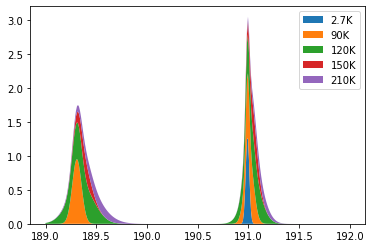

In [54]:
fig,ax=plt.subplots()
ax.stackplot(fitted_data_normalised[:,0],fitted_data_normalised[:,1], fitted_data_normalised[:,3], fitted_data_normalised[:,5], fitted_data_normalised[:,7], fitted_data_normalised[:,9],labels=['2.7K','90K','120K','150K','210K'])
ax.legend()
        